# Управление рисками 2024. Домашнее задание №3.

*Дата выдачи: 10.04.2024*

*Дедлайн: 24.04.2024, 23:59*

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_40787/2029515143.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Привет!

В данном домашнем задании тебе предстоит построить кривые def rate и clo rate (подробные пункты перечислены ниже). Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score и PD (**data_scores.csv**). Не бойся выходить за рамки методов, предложенных в лекции. Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям. 

Удачи!

#### Как будет оцениваться ваша работа:
За это ДЗ ты можешь получить максимум **10 баллов**. Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматься в случае неполного выполнения задания или отсутствия аргументации.


#### Задачи:

1) Построить кривые DEF rate (5 баллов)
    - Выбрать переменную для разбивки по бакетам (0.5 балла)
    - Провести анализ поколений (0.5 балла)
    - Построить винтажи CLO rate (0.5 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Провести анализ наличия внешних воздействий и при необходимости вычистить кривые (2 балла)
    - Построить среднее по винтажам для каждого бакета (0.5 балла)
    - Сгладить кривые (0.5 балла)
    
2) Построить кривые CLO rate (5 баллов)
    - Пункты, аналогчные DEF rate
    
**Пожалуйста, аргументируйте свои решения по каждому пункту**

В качестве результата по пунктам 2 и 3 приложите текущий ноутбук с названием 'Surname_clo.ipynb'

## Кривые CLO rate

#### Выгружаем данные с винтажами

Ссылка для скачивания: https://data.tinkoff.ru/s/J2yPgkyJTytxmYB

In [2]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv
df = pd.read_csv(
    './data/data_vintages.csv',
    sep=";",
    encoding="cp1251",
    index_col=0,
    date_format='%Y-%m-%d', #преобразуем даты
    parse_dates=['gen_month_dt', 'gen_quarter_dt']
)
df.head(10)

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
5,13089,14,2019-03-01,2019-01-01,0,0,0,1,0,0,0,1
6,132017,7,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
7,67966,24,2019-06-01,2019-04-01,1,0,0,0,1,0,0,0
8,152759,11,2019-11-01,2019-10-01,0,0,1,1,0,0,0,1
9,128462,20,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0


#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [3]:
# Тебе понадобятся два скора: 
# 1) x_score из файла data_scores.csv 
# 2) PD (вероятность дефолта за 12 месяцев), который вы получили в предыдущем ДЗ
df_scores = pd.read_csv(
    './data/data_scores.csv',
    sep=";",
    encoding="cp1251",
    decimal=',',
    index_col=0
)

df_scores.head(10)

,user_id,pd,x_score
0,9311,0.035025,0.219980
1,155026,0.046279,0.146986
2,17584,0.007221,0.343298
3,156231,0.069679,0.186684
4,123587,0.010402,0.305582
5,125519,0.032667,0.261228
6,123890,0.027963,0.199389
7,82137,0.073694,0.113313
8,55227,0.011746,0.335474
9,124825,0.049237,0.227262


#### Бъем выборку на бакеты и джойним с данными с винтажами

In [5]:
# Разбей данные на 3 бакета по каждой переменной
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,2,0.021296,0.469410
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0,2,0,0.064742,0.157215
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1,0,2,0.018490,0.469583
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,1,0.025882,0.210896
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0,1,1,0.024330,0.269492


### Выбери переменную, которая делит кривые наилучшим образом (0.5 баллов)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

Т.к. CLO - невозвратная переменная, будем рассматривать rate  

### $$CLO rate_n = \frac{\#CLO_n - \#CLO_{n-1}}{\#ACT_{n-1}}$$

In [11]:
df_scores.groupby(['x_bucket'])['x_score'].mean().to_csv('./clo_pa.csv')
df_scores.groupby(['pd_bucket'])['pd'].mean().to_csv('./clo_pd.csv')

### Выберем параметр для разделения кривых

#### Разделение по PD

In [5]:
def plot_clo_rate_by_bucket(df, bucket):
    return (df.query(''' gen_month_dt == '2019-04-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"clo_flg":'sum', "prev_clo_flg":'sum', "prev_act_flg":'sum', "user_id":np.count_nonzero})\
            .rename(columns = ({"clo_flg":'clo_cnt', "prev_clo_flg":'prev_clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
            .eval('clo_rate = (clo_cnt - prev_clo_cnt) / prev_act_cnt', inplace=False)\
            .unstack(bucket)
            ['clo_rate']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

/tmp/ipykernel_38163/3827922921.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return (df.query(''' gen_month_dt == '2019-04-01' ''')


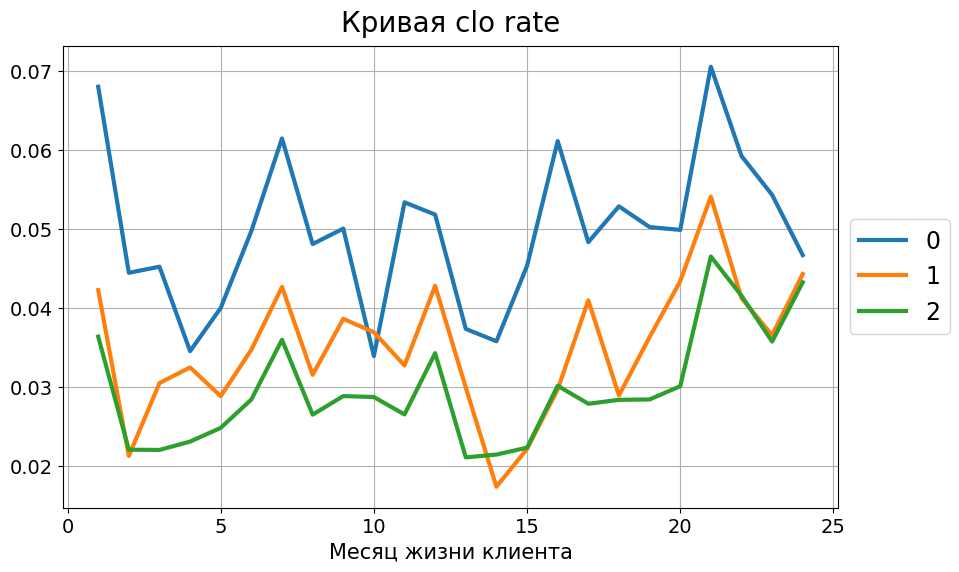

In [6]:
plot_clo_rate_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Разделение по X_score

/tmp/ipykernel_38163/3827922921.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return (df.query(''' gen_month_dt == '2019-04-01' ''')


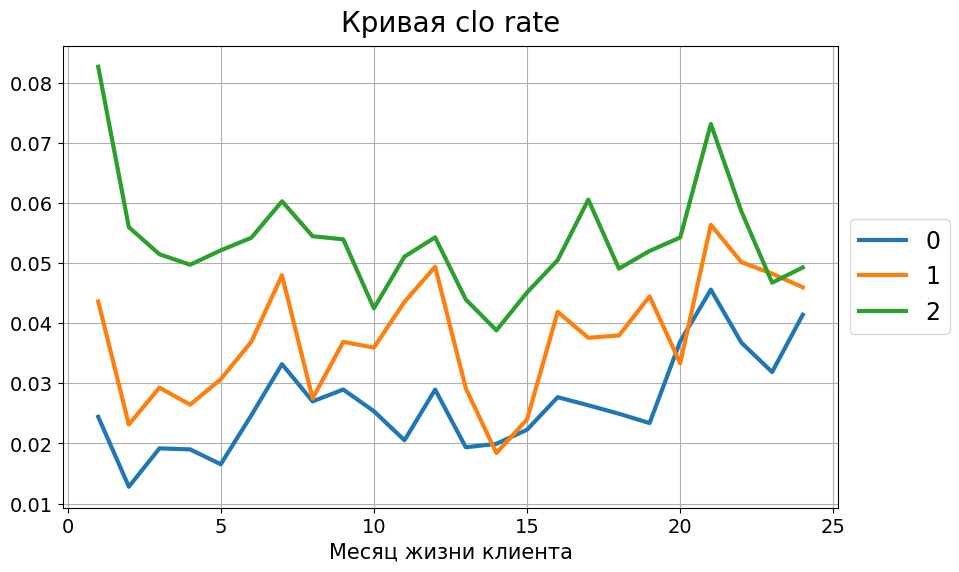

In [7]:
plot_clo_rate_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: При использовании X_score кривые лежат дальше друг от друга, чем при использовании PD, а также не так сильно их точки накладываются друг на друга, поэтому будем использовать X_score

### Анализ поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

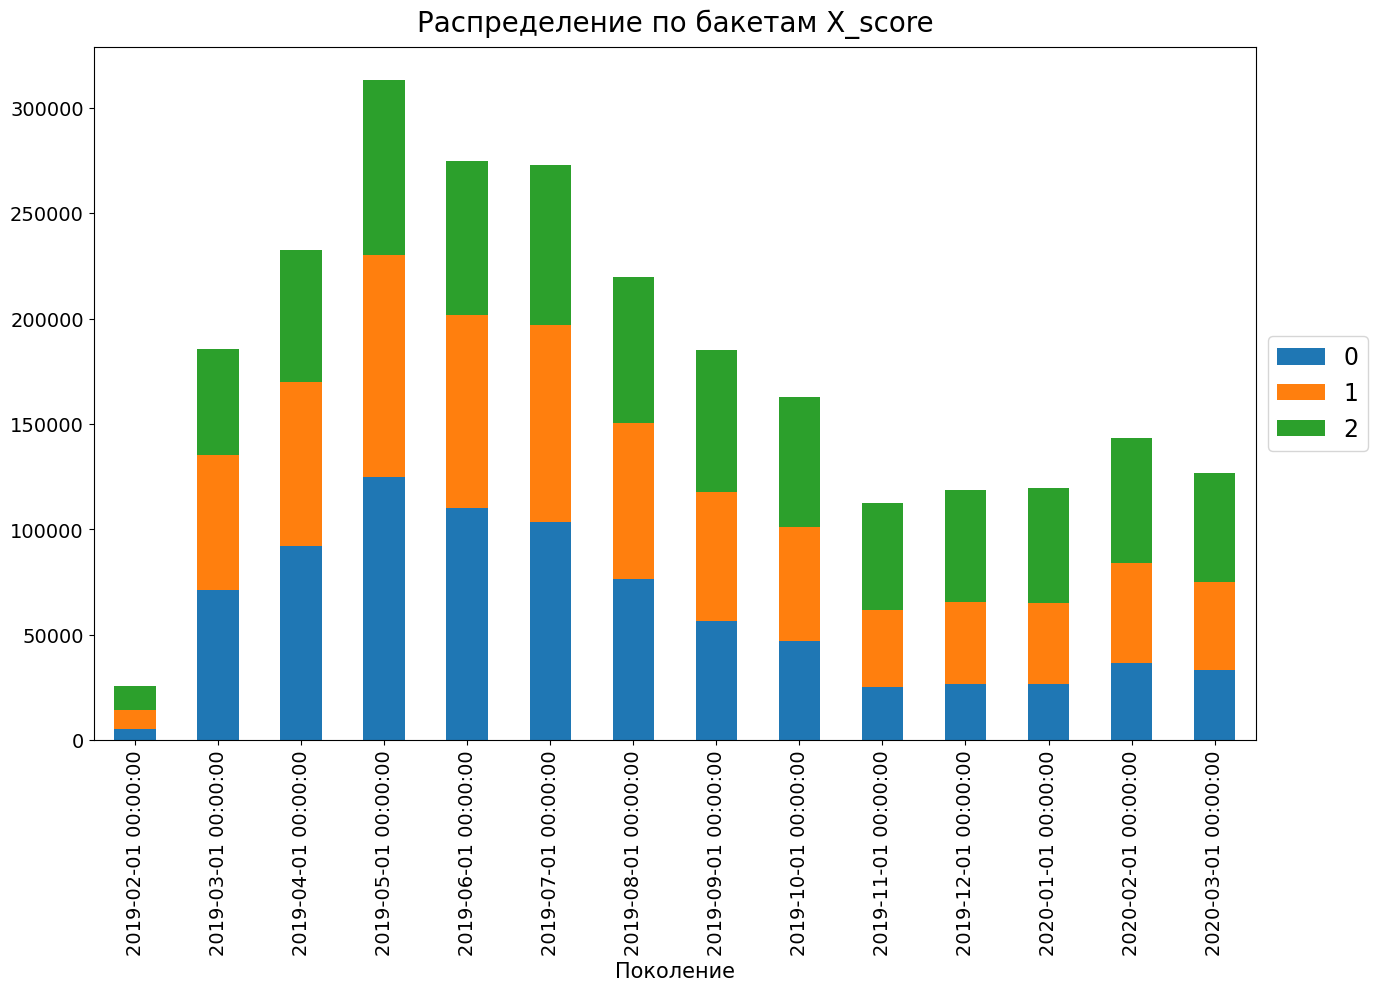

In [8]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))

plot_distribution(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам X_score", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: сделай выводы по полученным графикам. Нужно ли исключать какие-то бакеты/поколения? Если да, то реализуй их исключение из выборки

В феврале 2019 года мало наблюдений (25000 на три бакета по 24 платежа), исключим это поколение из рассмотрения 

In [9]:
# Исключаем плохое поколение

exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
df.query(exception_query, inplace = True)

/tmp/ipykernel_38163/2445818487.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df.query(exception_query, inplace = True)


### Кривые СLO Rate в разбивке по бакетам (0.5 баллов)

Реализуй функцию, которая отрисовывает винтажи CLO rate в разбивке по бакетам

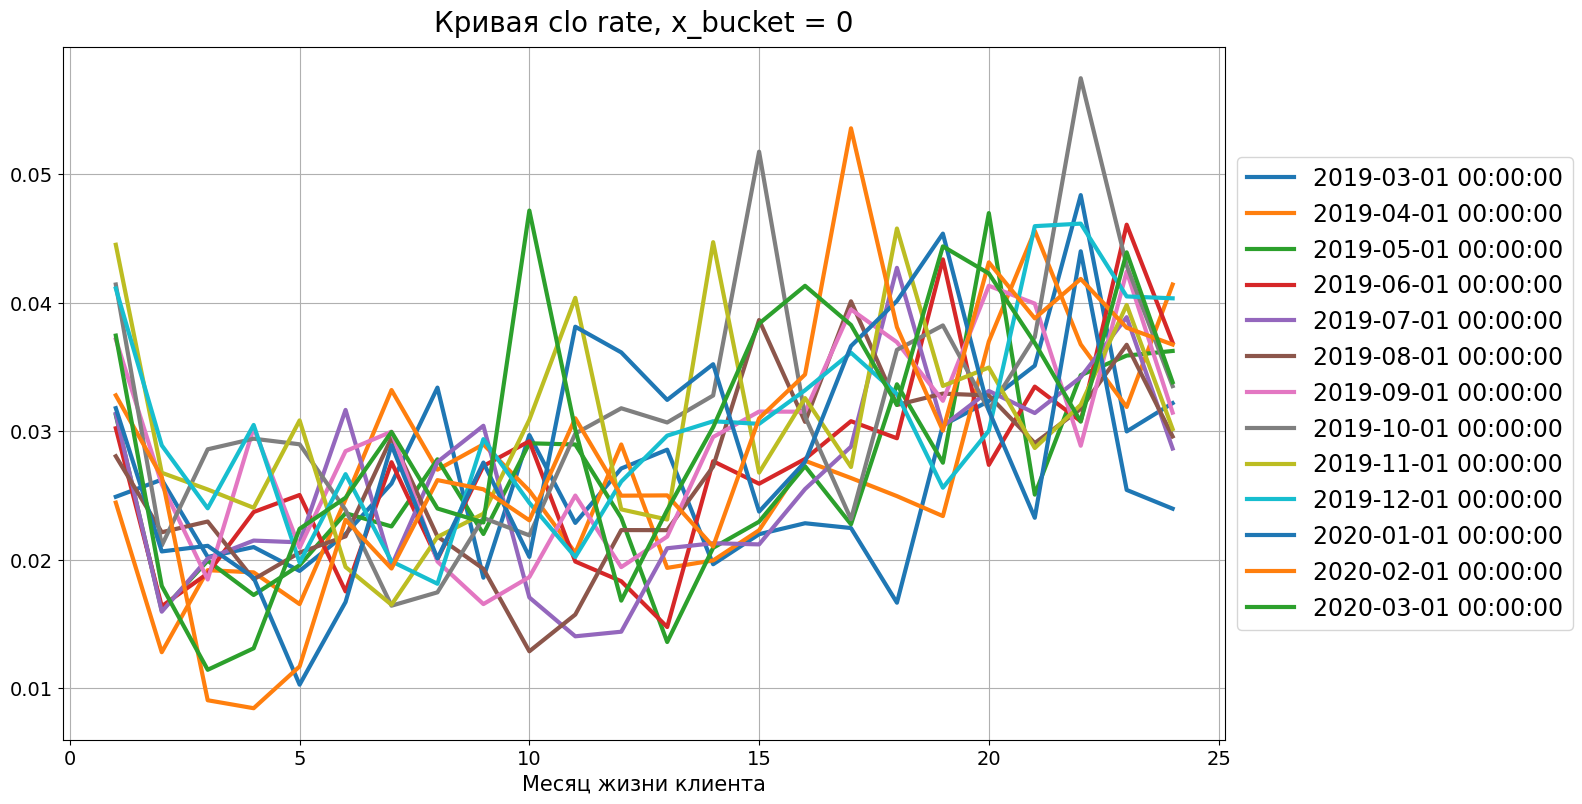

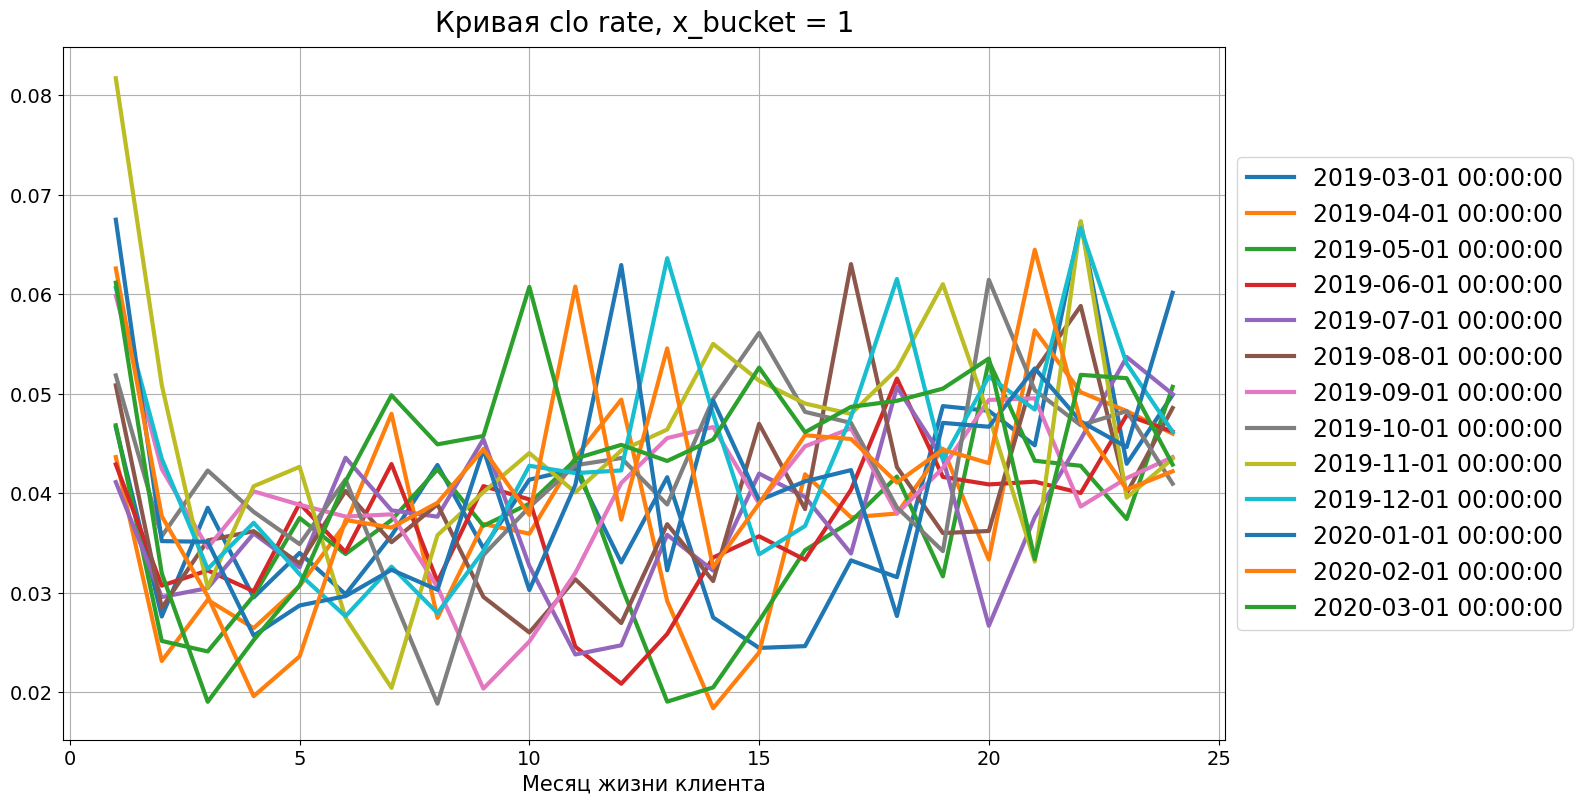

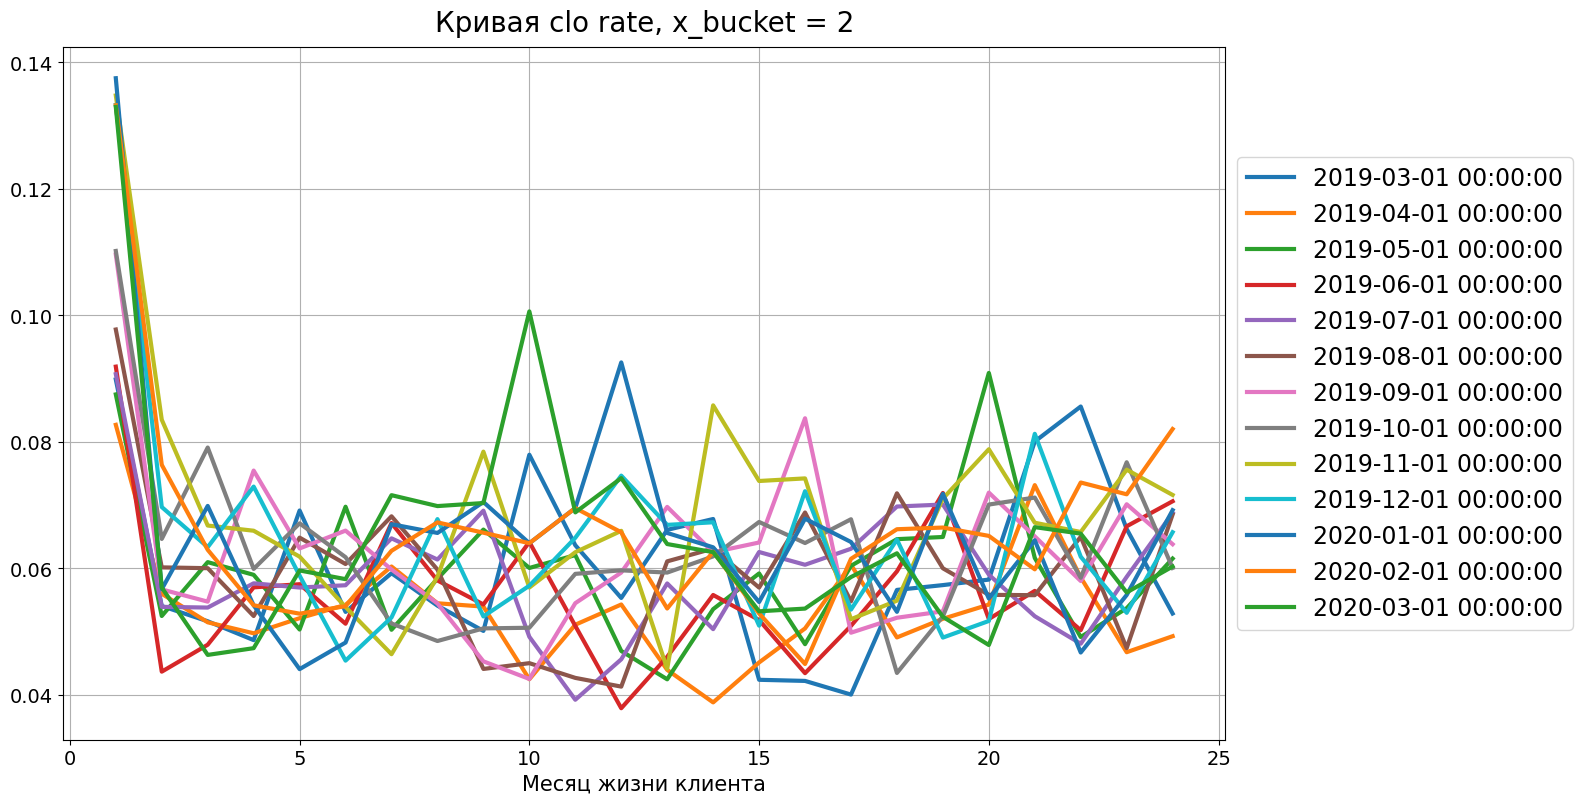

In [10]:
# Делаем список бакетов
buckets = df['x_bucket'].drop_duplicates().sort_values(ascending = True)

# Строим график, который зависит от бакета
def plot_clo_rate_by_generation(data, x_bucket):
    data_tmp = data.query(''' x_bucket == @x_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
        .agg({"clo_flg":'sum', "prev_clo_flg":'sum', "prev_act_flg":'sum', "user_id":np.count_nonzero})\
        .rename(columns = ({"clo_flg":'clo_cnt', "prev_clo_flg":'prev_clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
        .eval('clo_rate = (clo_cnt - prev_clo_cnt) / prev_act_cnt', inplace=False)\
        .unstack('gen_month_dt')['clo_rate']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая clo rate, x_bucket = " + str(x_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_clo_rate_by_generation(df, i)

#### Выводы: сделай выводы по полученным графикам

### Особые точки (0.5 баллов) 
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?



- В винтажах присутствуют пики(например, досрочное погашение: абсцисс 0)  
- В винтажах присутствуют выбросы: в течении всех месяцов жизни клиента в каждом бакете   
#### выбросы нужно сгладить, пики оставляем

### Макроэкономические воздействие (2 балла)

#### Есть ли в винтажах CLO rate макроэкономическое воздействие (нарисуй график иллюстрирующее это воздействие)? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния 
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи Clo rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

In [11]:
def curve_build(data,
                feature,
                generation='generation_quart',
                statement_num='statement_num',
                group_label='1'):
    """Вспомогательная функция для построения разложения в рамках одного бакета
    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """
    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])

    for i in range(tab_size):
        dates[i] = df_query.loc[i, generation].year * 12 + df_query.loc[i, generation].month -\
        generation_min.year * 12 - generation_min.month + df_query.loc[i, statement_num] - 1

    # Определяем функционал, который будем минимизировать
    def r_square(x):
        temp = 0
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt]) ** 2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями
    x0 = np.array([0.001 for i in range(2*gen_cnt)]) # Внешние воздействия #!!!

    # Численная минимизация
    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell',
                    options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months=i) for i in range(gen_cnt)],
                                  group_label: res0.x[: gen_cnt]})
    # external_data['month_dt'] = pd.to_datetime(external_data['month_dt']) #!!!

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице.
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months=6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean

    # И умножаем на полученный коэффициент кривые созревания
    maturation_array = np.transpose([res0.x[gen_cnt: 2 * gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array,
                                           'statement_num': np.arange(1, maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on='month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res

def decomposition(df, 
                  generation = 'generation_month', 
                  group = 'bucket', 
                  statement_num = 'statement_num', 
                  feature = 'feature', 
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени
    
    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов
 
    if optimization_query == '':
        df_query = pd.DataFrame(df)
        df_query[generation] = pd.to_datetime(df_query[generation])

    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta
    df_query['month_dt'] = pd.to_datetime(df_query['month_dt'])
    
      # Формируем список бакетов
    
    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())
    
    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))
        
        # Строим разложение для одного бакета
        res = curve_build(df_temp, 
                          feature = feature, 
                          generation = generation, 
                          statement_num = statement_num, 
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp]) 
        i+=1
        
    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }    
    return res_multiple

### Разложение кривых

In [12]:
df_rate = df.groupby(["x_bucket","gen_month_dt", "statement_num"], as_index=False)\
        .agg({"clo_flg":'sum', "prev_clo_flg":'sum', "prev_act_flg":'sum', "user_id":np.count_nonzero})\
        .rename(columns = ({"clo_flg":'clo_cnt', "prev_clo_flg":'prev_clo_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
        .eval('clo_rate = (clo_cnt - prev_clo_cnt) / prev_act_cnt', inplace=False)


# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых 
res = decomposition(df_rate, 
                       generation = 'gen_month_dt', 
                       group = 'x_bucket', 
                       statement_num = 'statement_num', 
                       feature = 'clo_rate')

/tmp/ipykernel_38163/266946895.py:120: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query['month_dt'] = df_query[generation] + timedelta


x_bucket = 0
Initial 0.272563
0  0.106618
1  0.106394
2  0.106379
3  0.106374
4  0.106372
5  0.106370
6  0.106370
7  0.106369
8  0.106369
9  0.106369
x_bucket = 1
Initial 0.542670
10  0.179463
11  0.178714
12  0.178619
13  0.178578
14  0.178558
15  0.178547
16  0.178541
17  0.178538
18  0.178536
19  0.178535
20  0.178535
21  0.178535
22  0.178535
x_bucket = 2
Initial 1.262832
23  0.321022
24  0.313791
25  0.312063
26  0.311241
27  0.310815
28  0.310592
29  0.310475
30  0.310414
31  0.310382
32  0.310365
33  0.310356
34  0.310351
35  0.310349
36  0.310348
37  0.310347
38  0.310347
39  0.310347


### Внешнее воздействие

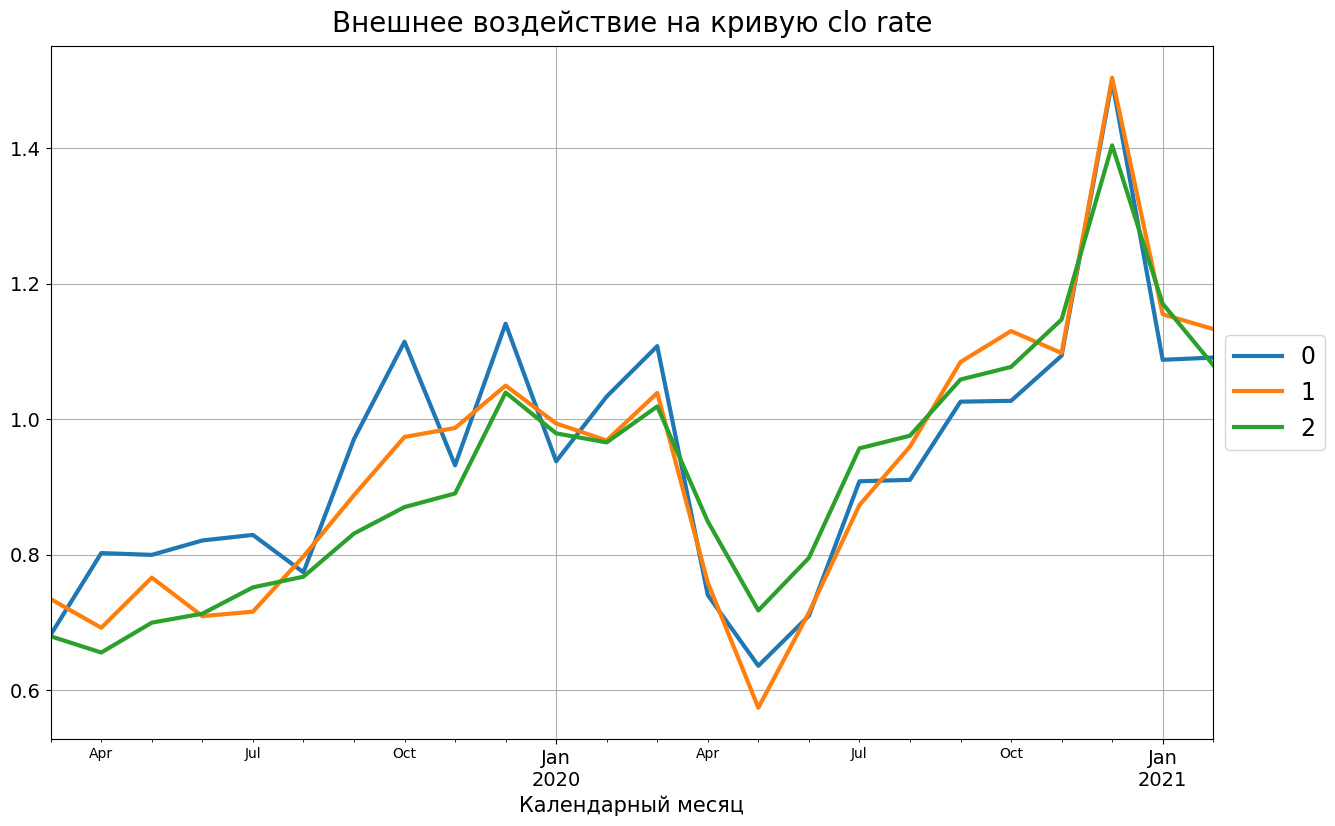

In [13]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешнее воздействие на кривую clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

brexit + коронавирус в октябре - декабре: сначало стабильно все больше и больше людей выплачивали кредит, однако из-за данных событий уменьшился их процент

### Вычищенная кривая clo rate

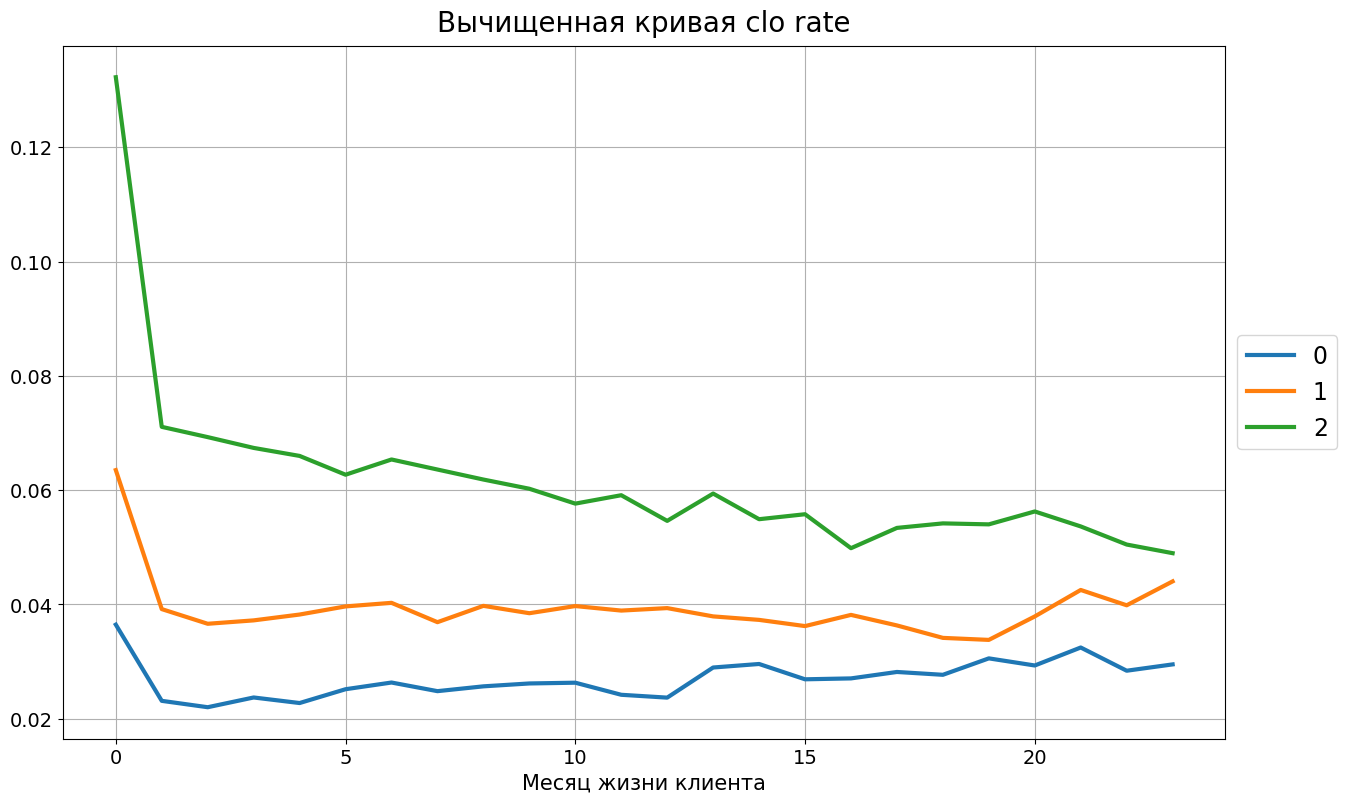

In [14]:
res['maturation_data'][:].drop(['statement_num'], axis=1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Вычищенная кривая clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Среднее по бакетам (0.5 баллов) 
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

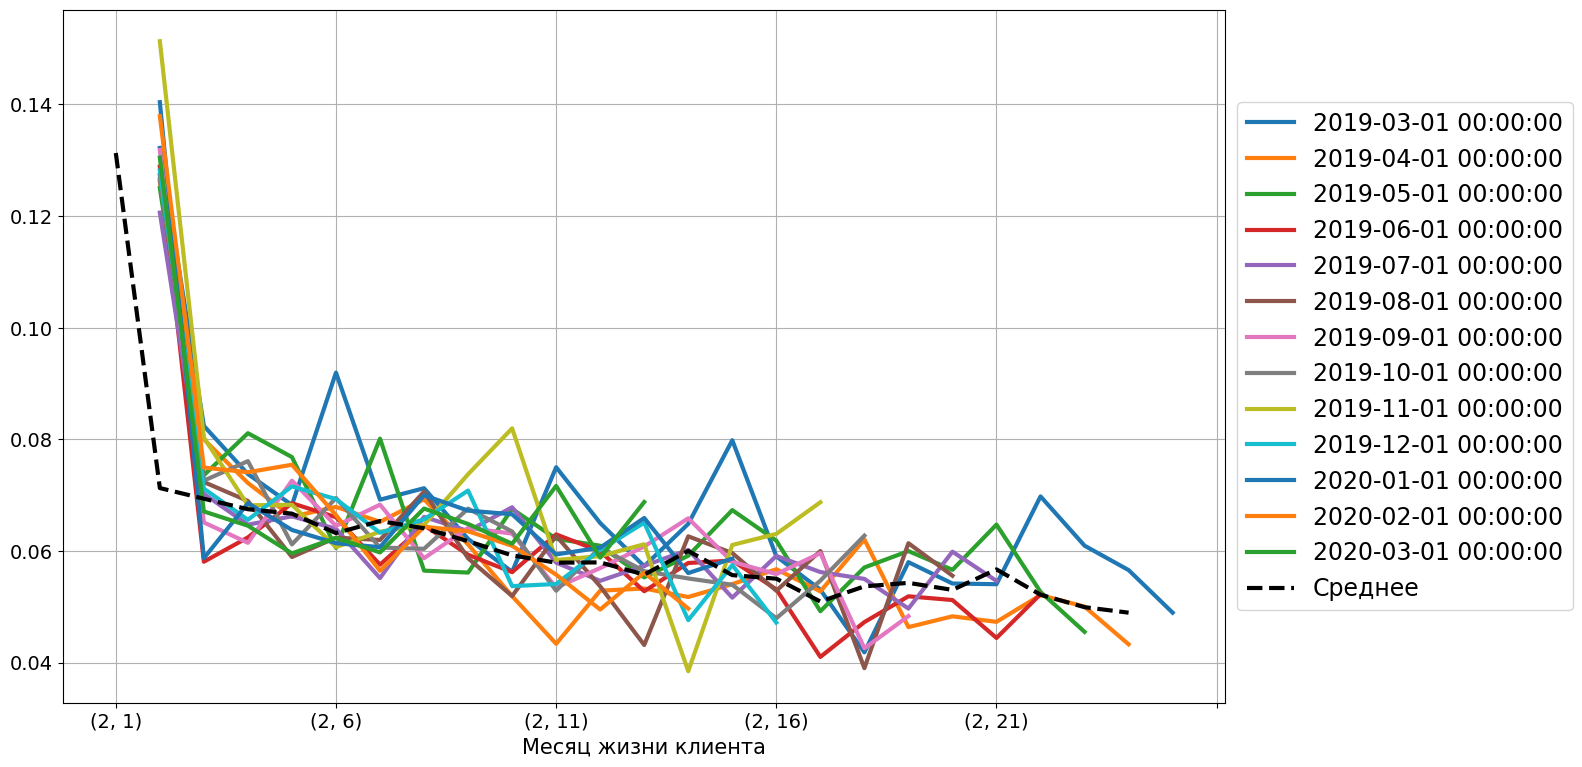

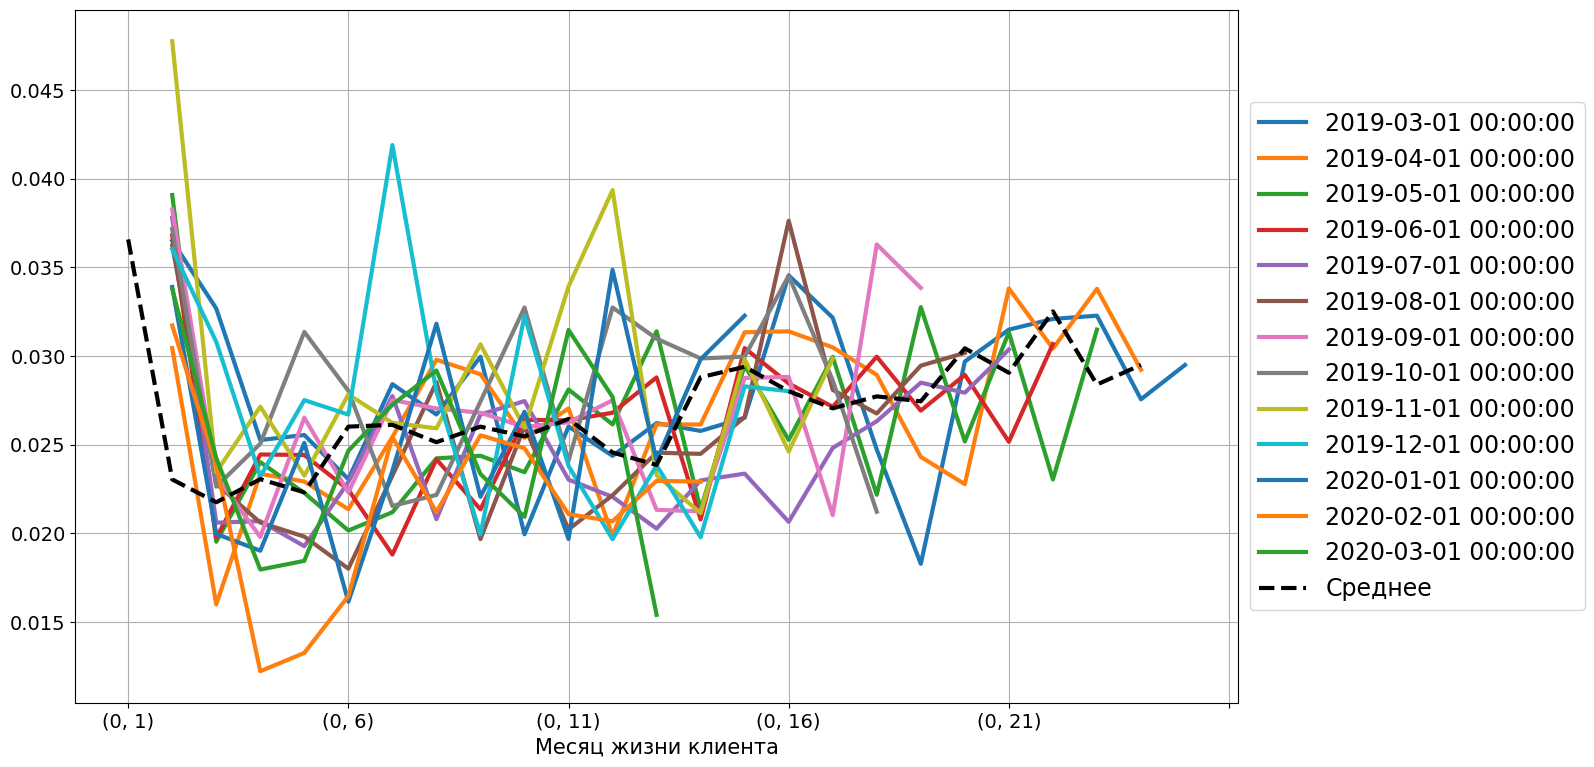

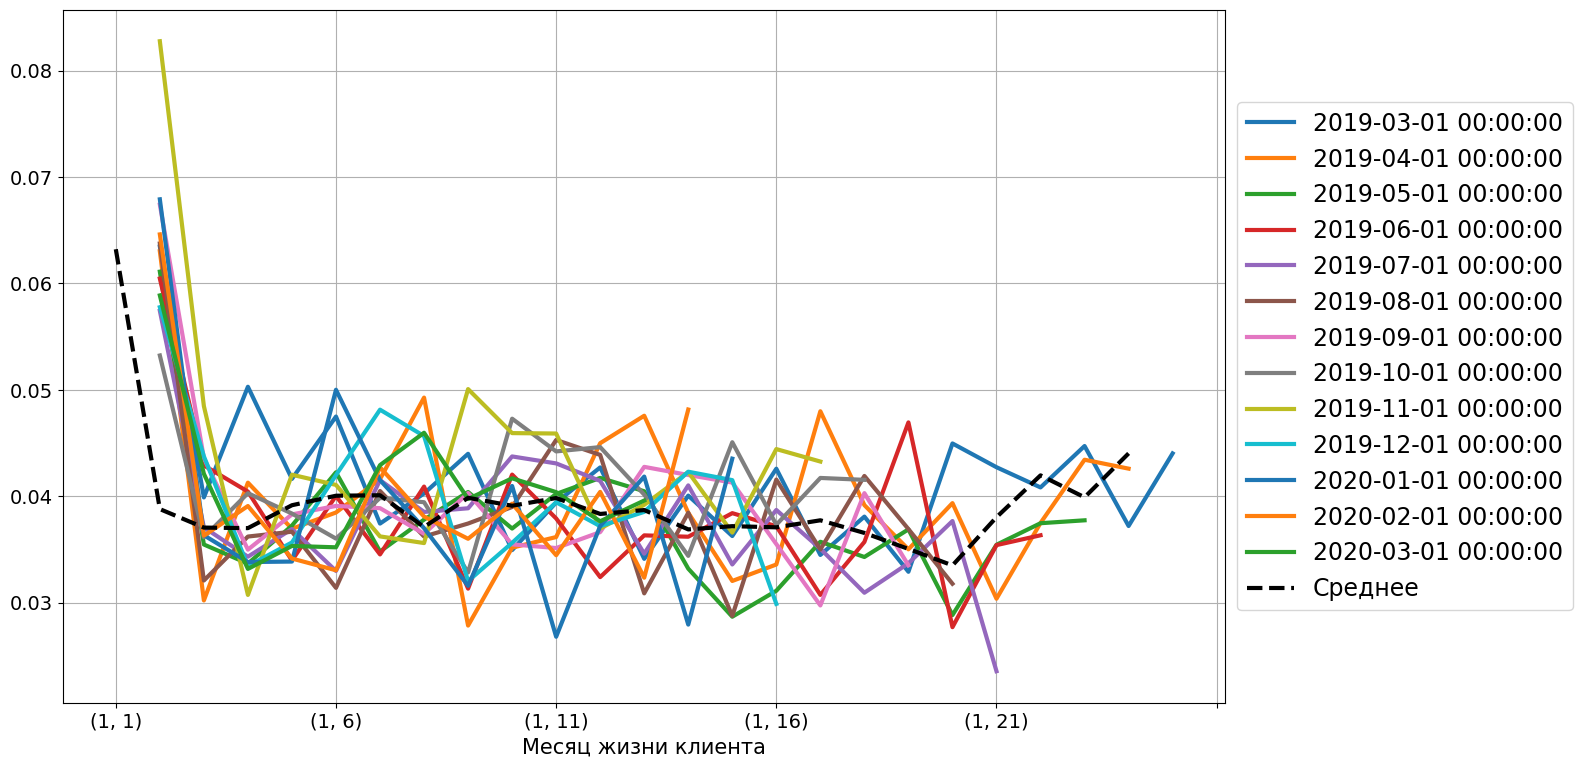

In [15]:
# Считаем среднее

clo_rate_mean = res['fitted_data'].groupby([ 'x_bucket', 'statement_num'])\
    .agg({'fitted_feature':'mean'})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['x_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_clo_rate_mean(pd_bucket):
    vintages_graph = res['fitted_data'].query('x_bucket == ' + str(pd_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":'sum'})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (clo_rate_mean.query('x_bucket == ' + str(pd_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 3, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    # plt.title("Кривая clo ratio, x_bucket =" + str(pd_bucket), "", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_clo_rate_mean(i)

### Сглаживание средних кривых (0.5 баллов) 

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

### Найдем лучшую функцию для сглаживания кривых

In [16]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res

def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

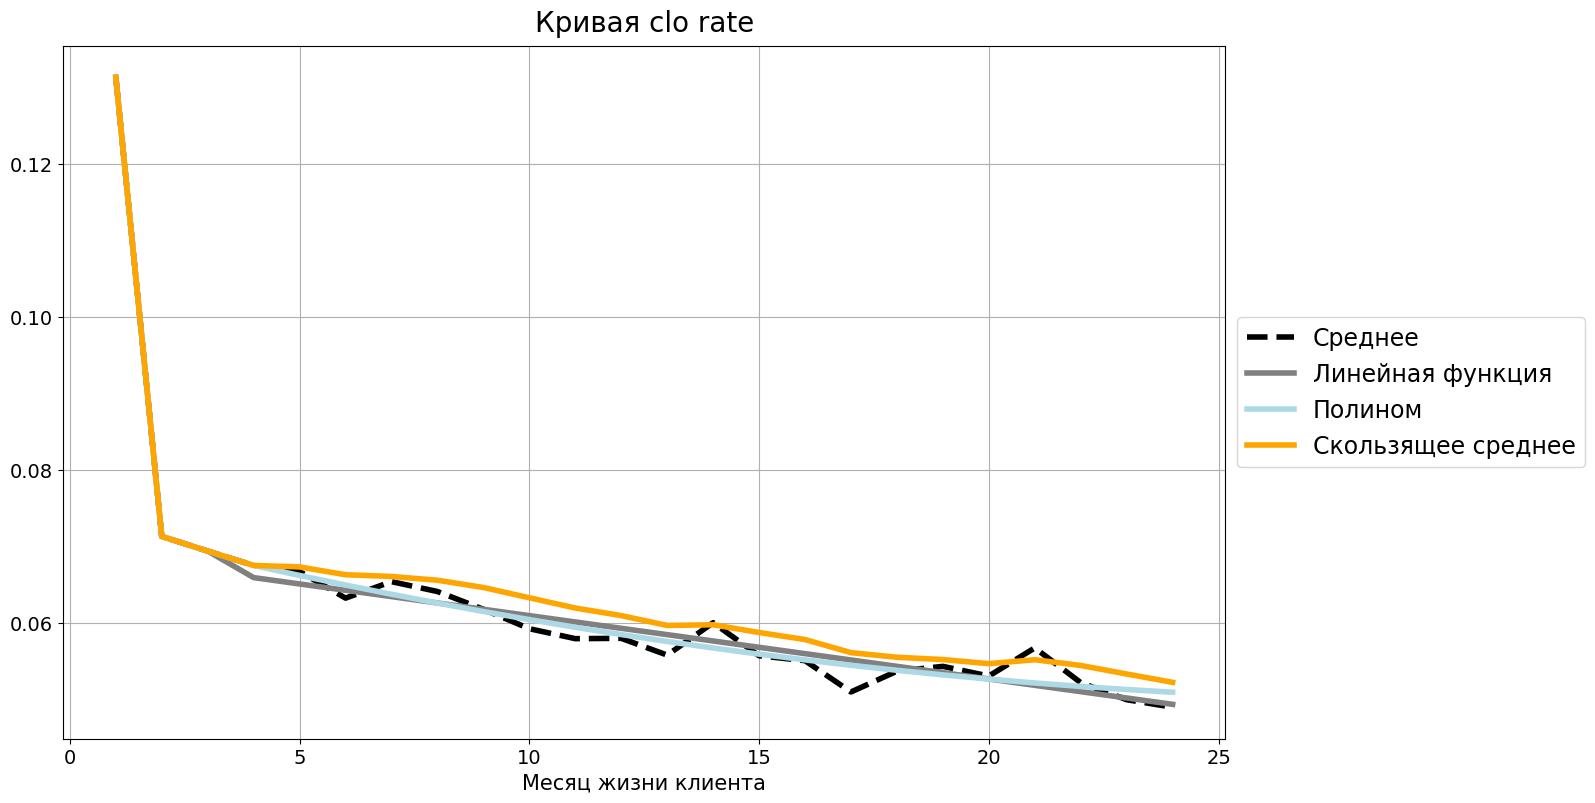

In [17]:
df_linear = clo_rate_mean.query('x_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4,24,2)
df_smooth = exponential_smoothing(df_polynom, 4,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая clo rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил сглаживание? Почему?

По моему мнению, линейная функция лучше описывает данную кривую, т.к. видно, что при их продолжении, полином будет расти медленнее, чем среднее, скользящее среднее зачастую дает большую погрешность, а линейная функция +- также

### Отрисуй сглаженные кривые по всем трем бакетам PD

0.061742819479545706
0.027023859093254162
0.03941743251868911


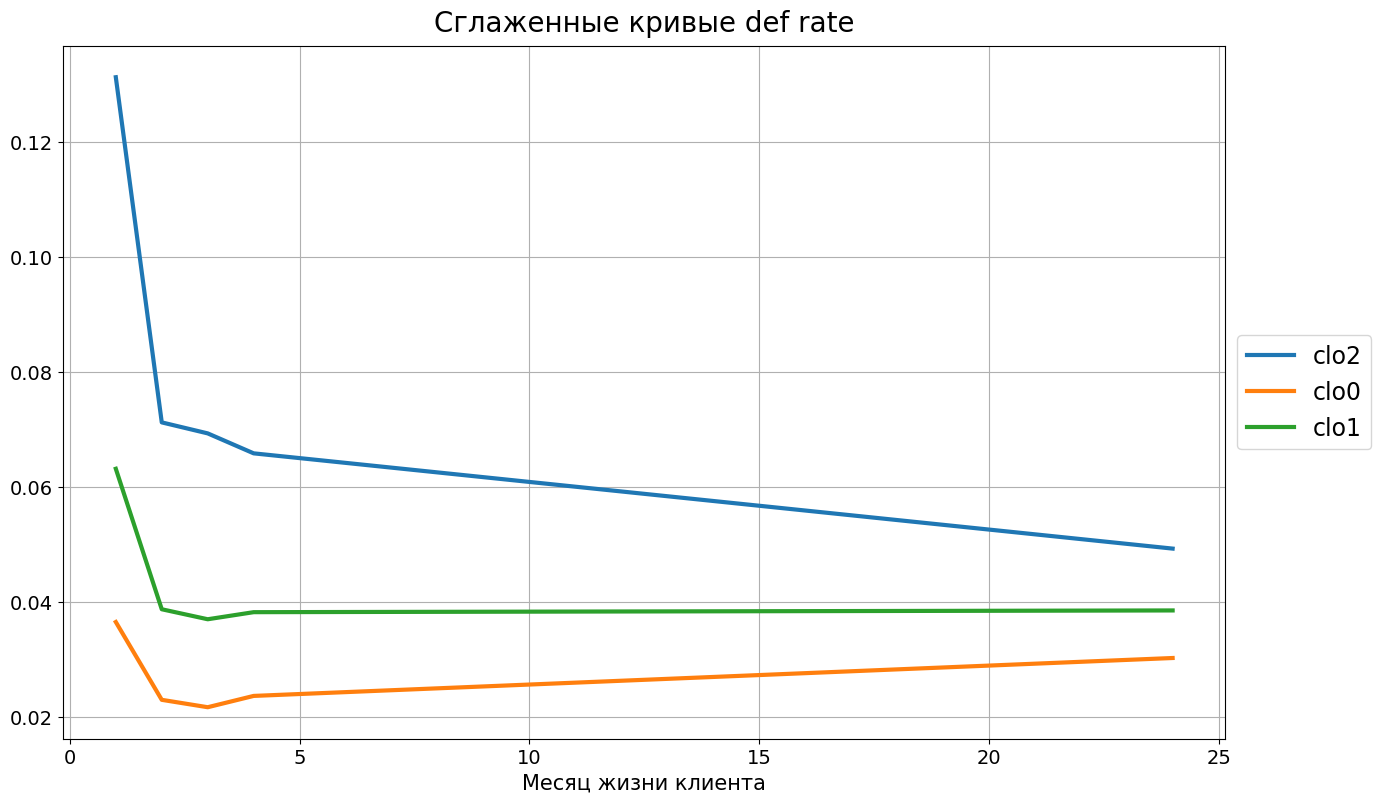

In [28]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['x_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = clo_rate_mean.query('x_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    ans = linear_approximation(df_temp, 4, 24)
    df_smooth_result[f'clo{bucket}'] = ans['Линейная функция']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые def rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [22]:
df_smooth_result.to_csv('clo_rate.csv')